#  量子神经网络

##  一 环境准备

请安装如下库：<br />
qutrunk 0.1.15 <br />
torch 1.13.0+cu116 <br />
torchvision 0.14.0 <br />
torchaudio 0.13.0

## 二 使用QuTrunk创建量子电路

In [1]:
import numpy as np
import json

from qutrunk.circuit import QCircuit
from qutrunk.circuit.gates import H, Ry, Measure, Barrier


class QuantumCircuit:

    def __init__(self, shots=100):
        self.shots = shots

    def _new_circuit(self, theta):
        # Create quantum circuit
        self._circuit = QCircuit()
        # Allocate quantum qubits
        qr = self._circuit.allocate(1)
        # apply gates
        H * qr[0]
        Barrier * qr
        Ry(theta) * qr[0]
        # measure
        Measure * qr[0]

    def run(self, theta):
        self._new_circuit(theta)

        result = self._circuit.run(shots=self.shots)
        result = result.get_counts()
        result = json.loads(result)

        counts = []
        states = []
        for r in result:
            for key, value in r.items():
                states.append(int(key, base=2))
                counts.append(value)

        states = np.array(states).astype(float)
        counts = np.array(counts)

        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)

        return np.array([expectation])


In [2]:
circuit = QuantumCircuit()
print(f'Expected value for rotation pi= {circuit.run(np.pi)[0]}')

Expected value for rotation pi= 0.51


## 三 加载训练数据集和测试数据集

In [3]:
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [4]:
# train dataset
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples],
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [5]:
# test dataset
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples],
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [6]:
def show_data():
    n_samples_show = 6

    data_iter = iter(train_loader)
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

    while n_samples_show > 0:
        images, targets = data_iter.__next__()

        axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
        axes[n_samples_show - 1].set_xticks([])
        axes[n_samples_show - 1].set_yticks([])
        axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))

        n_samples_show -= 1


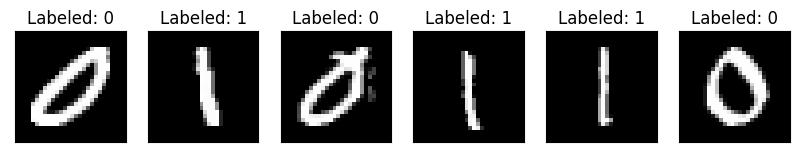

In [8]:
# show data
show_data()